# Jitter Buffer Delay box plots

In [1]:
import sys
from dotenv import load_dotenv
from datetime import datetime, timedelta
import pandas as pd
import os
import json
import logging
import matplotlib.pyplot as plt
import helperFunctions as hf
import numpy as np

hf.setup()

callAndOutcomeFile = "output_folder/UniqueCallsAndOutcomes.csv"
outputFolder = "output_folder/"


if not os.path.exists(outputFolder):

   # Create a new directory because it does not exist
   os.makedirs(outputFolder)
   logging.info(f"The directory \"{outputFolder}\" is created!")

In [2]:
df = pd.DataFrame(columns=["scenario", "client", "mediaType", "avgJitterBufferDelay"])

callsDf = pd.read_csv(callAndOutcomeFile)

# filter for calls with state success
successCallsDf = callsDf.loc[callsDf["logging_type"] == "COMMAND_SESSION_SUCCESS"]

for scenario in hf.scenarios:
  s = scenario["scenario"]
  a = scenario["alice"]
  b = scenario["bob"]
  logging.info(f"Starting on scenario {s}, alice: {a}, bob: {b}")

  # filter for calls with scenario_type s
  scenarioCallsDf = successCallsDf.loc[successCallsDf["scenario_type"] == s]

  # get list of room_ids in scenarioCallsDf
  roomIds = scenarioCallsDf["room_id"].unique()

  reportForClientA = pd.read_csv(f"output_folder/rawReport/{a}.csv")
  JitterBufferDelay = reportForClientA[(reportForClientA["type"] == "inbound-rtp") & (reportForClientA["roomId"].isin(roomIds)) & (reportForClientA["mediaType"] == "video") & (reportForClientA["jitterBufferDelay"] > 0)  & (reportForClientA["jitterBufferEmittedCount"] > 0)  ]["jitterBufferDelay"]
  JitterBufferEmittedCount = reportForClientA[(reportForClientA["type"] == "inbound-rtp") & (reportForClientA["roomId"].isin(roomIds)) & (reportForClientA["mediaType"] == "video") & (reportForClientA["jitterBufferDelay"] > 0)  & (reportForClientA["jitterBufferEmittedCount"] > 0)  ]["jitterBufferEmittedCount"]
  avgJitterBufferDelay = JitterBufferDelay / JitterBufferEmittedCount
  dataVideoA = pd.DataFrame(columns=["scenario", "client", "mediaType", "avgJitterBufferDelay"]).assign(avgJitterBufferDelay=avgJitterBufferDelay)
  dataVideoA = dataVideoA.assign(scenario=s, client=a, mediaType="video")

  # Remove inputs where 


  reportForClientB = pd.read_csv(f"output_folder/rawReport/{b}.csv")
  JitterBufferDelay = reportForClientB[(reportForClientB["type"] == "inbound-rtp") & (reportForClientB["roomId"].isin(roomIds)) & (reportForClientB["mediaType"] == "video") & (reportForClientB["jitterBufferDelay"] > 0)  & (reportForClientB["jitterBufferEmittedCount"] > 0) ]["jitterBufferDelay"]
  JitterBufferEmittedCount = reportForClientB[(reportForClientB["type"] == "inbound-rtp") & (reportForClientB["roomId"].isin(roomIds)) & (reportForClientB["mediaType"] == "video") & (reportForClientB["jitterBufferDelay"] > 0)  & (reportForClientB["jitterBufferEmittedCount"] > 0) ]["jitterBufferEmittedCount"]
  avgJitterBufferDelay = JitterBufferDelay / JitterBufferEmittedCount
  dataVideoB = pd.DataFrame(columns=["scenario", "client", "mediaType", "avgJitterBufferDelay"]).assign(avgJitterBufferDelay=avgJitterBufferDelay)
  dataVideoB = dataVideoB.assign(scenario=s, client=b, mediaType="video")

  df = pd.concat([df, dataVideoA,  dataVideoB], ignore_index=True)

logging.info(f"df shape: {df.shape}")

# save plotDf to csv
df.to_csv(f"{outputFolder}/avgJitterBufferDelayPlotDf.csv",index=False, header=True, encoding='utf-8', mode='w')


2023-01-31 16:09:08 INFO     Starting on scenario 1, alice: c1-Normal, bob: d1-Normal 
2023-01-31 16:09:15 INFO     Starting on scenario 2, alice: c2-TorNormal, bob: d2-TorNormal 
2023-01-31 16:09:22 INFO     Starting on scenario 3, alice: c3-TorEurope, bob: d3-TorEurope 
2023-01-31 16:09:27 INFO     Starting on scenario 4, alice: c4-TorScandinavia, bob: d4-TorScandinavia 
2023-01-31 16:09:31 INFO     Starting on scenario 5, alice: c6-Lokinet, bob: d6-Lokinet 
2023-01-31 16:09:35 INFO     Starting on scenario 6, alice: c1-Normal, bob: d2-TorNormal 
2023-01-31 16:09:41 INFO     Starting on scenario 7, alice: c2-TorNormal, bob: d1-Normal 
2023-01-31 16:09:46 INFO     Starting on scenario 8, alice: c1-Normal, bob: d3-TorEurope 
2023-01-31 16:09:52 INFO     Starting on scenario 9, alice: c3-TorEurope, bob: d1-Normal 
2023-01-31 16:09:57 INFO     Starting on scenario 10, alice: c1-Normal, bob: d4-TorScandinavia 
2023-01-31 16:10:03 INFO     Starting on scenario 11, alice: c4-TorScandinavia,

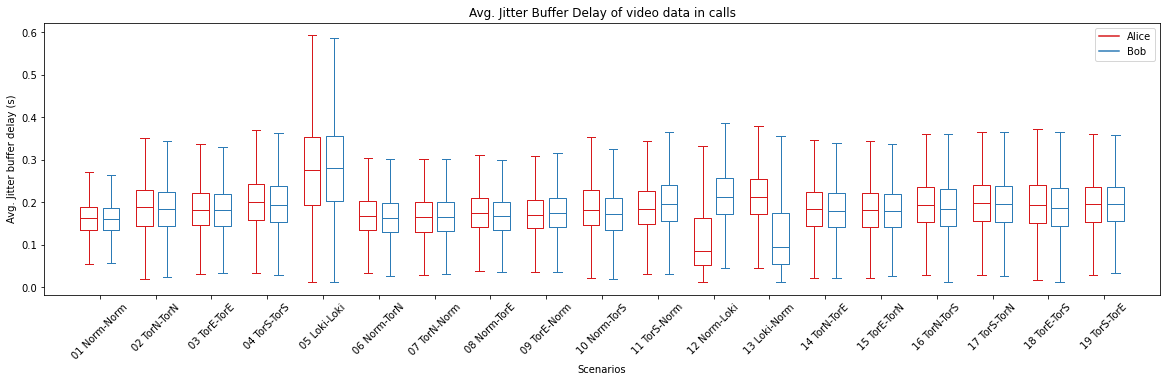

In [6]:
dataA = []
dataB = []
for scenario in hf.scenarios:
  s = scenario["scenario"]
  a = scenario["alice"]
  b = scenario["bob"]
  dataA.append(df.loc[(df["scenario"] == s) & (df["mediaType"] == "video") & (df["client"] == a)]["avgJitterBufferDelay"].values)
  dataB.append(df.loc[(df["scenario"] == s) & (df["mediaType"] == "video") & (df["client"] == b)]["avgJitterBufferDelay"].values)


  # Times 1000 to convert to ms.

def set_box_color(bp, color):
    plt.setp(bp['boxes'], color=color)
    plt.setp(bp['whiskers'], color=color)
    plt.setp(bp['caps'], color=color)
    plt.setp(bp['medians'], color=color)


plt.figure()

bpl = plt.boxplot(dataA, positions=np.array(range(len(dataA)))*2.0-0.4, sym='', widths=0.6)
bpr = plt.boxplot(dataB, positions=np.array(range(len(dataB)))*2.0+0.4, sym='', widths=0.6)
set_box_color(bpl, '#D7191C') # colors are from http://colorbrewer2.org/
set_box_color(bpr, '#2C7BB6')

# draw temporary red and blue lines and use them to create a legend
plt.plot([], c='#D7191C', label='Alice')
plt.plot([], c='#2C7BB6', label='Bob')
plt.legend()
plt.title("Avg. Jitter Buffer Delay of video data in calls")
plt.rcParams["figure.figsize"] = [20,5]

plt.xlabel('Scenarios')
ticks = hf.getScenarioLabels(df["scenario"].unique())
plt.xticks(range(0, len(ticks) * 2, 2), ticks, rotation=45)
plt.xlim(-2, len(ticks)*2)

#plt.ylim(0, 2500)
plt.ylabel('Avg. Jitter buffer delay (s)')


plt.savefig("output_folder/BoxPlotAvgJitterBufferDelayVideo.png", format="png", bbox_inches='tight', transparent=False, dpi=600, pad_inches=0.1, facecolor='w', edgecolor='w')
plt.savefig("output_folder/BoxPlotAvgJitterBufferDelayVideo.svg", format="svg", bbox_inches='tight', transparent=False, dpi=600, pad_inches=0.1, facecolor='w', edgecolor='w')
plt.show()

In [4]:
'''
dataA = []
dataB = []
for scenario in scenarios:
  s = scenario["scenario"]
  a = scenario["alice"]
  b = scenario["bob"]
  dataA.append(plotDf.loc[(plotDf["scenario"] == scenario["scenario"]) & (plotDf["mediaType"] == "audio") & (plotDf["client"] == scenario["alice"])]["jitter"].values)
  dataB.append(plotDf.loc[(plotDf["scenario"] == scenario["scenario"]) & (plotDf["mediaType"] == "audio") & (plotDf["client"] == scenario["bob"])]["jitter"].values)

  # Times 1000 to convert to ms.

def set_box_color(bp, color):
    plt.setp(bp['boxes'], color=color)
    plt.setp(bp['whiskers'], color=color)
    plt.setp(bp['caps'], color=color)
    plt.setp(bp['medians'], color=color)

plt.figure()

bpl = plt.boxplot(dataA, positions=np.array(range(len(dataA)))*2.0-0.4, sym='', widths=0.6)
bpr = plt.boxplot(dataB, positions=np.array(range(len(dataB)))*2.0+0.4, sym='', widths=0.6)
set_box_color(bpl, '#D7191C') # colors are from http://colorbrewer2.org/
set_box_color(bpr, '#2C7BB6')

# draw temporary red and blue lines and use them to create a legend
plt.plot([], c='#D7191C', label='Alice')
plt.plot([], c='#2C7BB6', label='Bob')
plt.legend()
plt.title("Jitter of audio data in calls")
plt.rcParams["figure.figsize"] = [20,5]

plt.xlabel('Scenarios')
ticks = getScenarioLabels(plotDf["scenario"].unique())
plt.xticks(range(0, len(ticks) * 2, 2), ticks, rotation=45)
plt.xlim(-2, len(ticks)*2)

plt.ylabel('Jitter (XX)')


plt.savefig("output_folder/BoxPlotJitterAudio.png", format="png", bbox_inches='tight', transparent=False, dpi=600, pad_inches=0.1, facecolor='w', edgecolor='w')
plt.savefig("output_folder/BoxPlotJitterAudio.svg", format="svg", bbox_inches='tight', transparent=False, dpi=600, pad_inches=0.1, facecolor='w', edgecolor='w')
plt.show()
'''

'\ndataA = []\ndataB = []\nfor scenario in scenarios:\n  s = scenario["scenario"]\n  a = scenario["alice"]\n  b = scenario["bob"]\n  dataA.append(plotDf.loc[(plotDf["scenario"] == scenario["scenario"]) & (plotDf["mediaType"] == "audio") & (plotDf["client"] == scenario["alice"])]["jitter"].values)\n  dataB.append(plotDf.loc[(plotDf["scenario"] == scenario["scenario"]) & (plotDf["mediaType"] == "audio") & (plotDf["client"] == scenario["bob"])]["jitter"].values)\n\n  # Times 1000 to convert to ms.\n\ndef set_box_color(bp, color):\n    plt.setp(bp[\'boxes\'], color=color)\n    plt.setp(bp[\'whiskers\'], color=color)\n    plt.setp(bp[\'caps\'], color=color)\n    plt.setp(bp[\'medians\'], color=color)\n\nplt.figure()\n\nbpl = plt.boxplot(dataA, positions=np.array(range(len(dataA)))*2.0-0.4, sym=\'\', widths=0.6)\nbpr = plt.boxplot(dataB, positions=np.array(range(len(dataB)))*2.0+0.4, sym=\'\', widths=0.6)\nset_box_color(bpl, \'#D7191C\') # colors are from http://colorbrewer2.org/\nset_box_co